In [2]:
import os,bs4
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential,get_bearer_token_provider
from langchain_openai import AzureChatOpenAI,AzureOpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.chroma import Chroma
from typing import  TypedDict,Literal,Annotated,Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langchain import hub
from pydantic import BaseModel,Field
from langgraph.graph import StateGraph,START,END

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
load_dotenv()
token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
az_chat_model= AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    model= "gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

embedding_model= AzureOpenAIEmbeddings(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    model= "text-embedding-ada-002"
)

In [4]:
len(embedding_model.embed_query("hai, hello how are you"))
#1536

1536

- LangGraph
- Crew AI
- Agno

###### Explore What is Agentic RAG


In [5]:
# Loading
loader= WebBaseLoader(web_paths=["https://lilianweng.github.io/posts/2023-06-23-agent/",
                        "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/"
                      ],
                      bs_kwargs=dict(
                            parse_only= bs4.SoupStrainer(
                                class_ = ("post-title","post-content","post-header")
                            )
                      )
                      )
documents= loader.load()

# Splitting

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size =1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

# Embedding and Storing
vector_db=Chroma.from_documents(
    collection_name= "rag-chroma",
    embedding= embedding_model,
    documents= chunks
)

retriever = vector_db.as_retriever()
retriever.invoke("what is agent and prompt?")



[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/'}, page_content="Prompt Engineering\n    \nDate: March 15, 2023  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng\n\n\nPrompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.\n[My personal spicy take] In my opinion, some prompt engineering papers are not worthy 8 pages long, since those tricks can be explained in 

In [6]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(retriever=retriever,name = "Blog-retriver",description= "This will fetch blog documents from Chroma DB")

tools =[retriever_tool]

In [7]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage],add_messages]

In [8]:
class grade(BaseModel):
    binary_score:str=Field(description="Relavance score 'yes' or 'no'")

In [25]:
from langchain_core.prompts import PromptTemplate



def llm_decision_maker(state : AgentState) ->AgentState:
    print("LLM Decision Maker Call.....")
    prompt=PromptTemplate(
    template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                    Here is the question:{question}
                    """,
                    input_variables=["question"]
                    )
    messages = state["messages"]
    if len(messages)>1:
        chain = prompt | az_chat_model
        response =  chain.invoke({"question":messages[0]})
        return {"messages": [response.content]}
    else:
         llm_with_tool= az_chat_model.bind_tools(tools=tools)
         response = llm_with_tool.invoke(messages)   
         return {"messages": [response]}


def grade_documents(state: AgentState)  ->Literal["generator","rewriter"] :
    print("Grade Called.....")
    az_structured_model = az_chat_model.with_structured_output(grade)
    messages = state["messages"]
    lastmessage = messages[-1].content
    question = messages[0].content
    template = """You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question."""
    prompt= PromptTemplate(
        template= template,
        input_variables=["context", "question"]
    )
    chain = prompt|az_structured_model
    scored_result=chain.invoke({"question": question, "context": lastmessage})
    score=scored_result.binary_score     
    if score=="yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"


def rewrite(state:AgentState) -> AgentState:
    print("---- Rewrite Call----")
    question = state["messages"][0].content
    prompt = PromptTemplate(
        template= """
                Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question:
            """,
            input_variables=["question"]
                    )
    chain = prompt | az_chat_model
    response = chain.invoke({"question" : question})
    print(response.content)
    return {"messages":[response]} 


def generate(state: AgentState)-> AgentState:
    """ This  """
    print("---- Generate Call----")
    question = state["messages"][0].content
    context = state["messages"][-1].content
    rag_prompt = hub.pull("rlm/rag-prompt")
    chain = rag_prompt | az_chat_model
    response = chain.invoke({"context": context, "question": question})
    return {"messages":[response]}


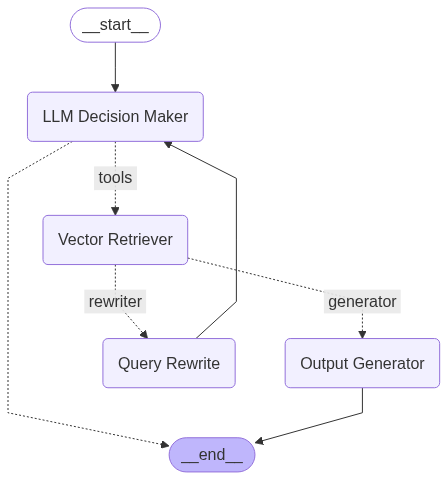

In [30]:
workflow = StateGraph(AgentState)


workflow.add_node("LLM Decision Maker",llm_decision_maker)
workflow.add_node("Vector Retriever",ToolNode(tools=tools))
workflow.add_node("Output Generator",generate)
workflow.add_node("Query Rewrite",rewrite)


workflow.add_edge(START,"LLM Decision Maker")
workflow.add_conditional_edges("LLM Decision Maker",tools_condition,
                                 {
                                     "tools" : "Vector Retriever",
                                     END:END
                                 }                    
                              )

workflow.add_conditional_edges("Vector Retriever",grade_documents,
                                 {
                                     "generator" : "Output Generator",
                                     "rewriter" : "Query Rewrite"
                                 }                    
                              )

workflow.add_edge("Output Generator",END)
workflow.add_edge("Query Rewrite","LLM Decision Maker")
compiledflow=workflow.compile()
compiledflow

In [22]:
compiledflow.invoke({"messages":"What is LLM Powered Autonomous Agent and Explain the planning and reflection"})

LLM Decision Maker Call.....
Grade Called.....
----DECISION: DOCS ARE RELEVANT----
---- Generate Call----


{'messages': [HumanMessage(content='What is LLM Powered Autonomous Agent and Explain the planning and reflection', additional_kwargs={}, response_metadata={}, id='a8830ca8-8ed2-4355-993e-34f5fac3b321'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w8tiTMKbgZ2TN6IoKWtqSDIU', 'function': {'arguments': '{"query":"LLM Powered Autonomous Agent planning and reflection"}', 'name': 'Blog-retriver'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 71, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-BklQYc9A9vSdw3A3gtl4noRdBPfNi', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'

In [23]:
compiledflow.invoke({"messages":"Hi How are you?"})

LLM Decision Maker Call.....


{'messages': [HumanMessage(content='Hi How are you?', additional_kwargs={}, response_metadata={}, id='66a55966-1aba-4899-bb05-81b12ed5e4c9'),
  AIMessage(content="I'm just a computer program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 63, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7a53abb7a2', 'id': 'chatcmpl-BklQdC8sHdx01flPfasKdmuXSp97U', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'sa

In [29]:
compiledflow.invoke({"messages":"How Chain of Hindsight help in Self-Reflection agent systems?"})

LLM Decision Maker Call.....
Grade Called.....
----DECISION: DOCS ARE RELEVANT----
---- Generate Call----


{'messages': [HumanMessage(content='How Chain of Hindsight help in Self-Reflection agent systems?', additional_kwargs={}, response_metadata={}, id='dc973b26-266d-4402-bab3-79773c987ed5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4618oYEbgSSfvExr113M72Aw', 'function': {'arguments': '{"query":"Chain of Hindsight Self-Reflection agent systems"}', 'name': 'Blog-retriver'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 71, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-BklWdgWiOhREs1XBWZ1GcLuu4i0XO', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, '